# Coherence Analysis

## Approach 1: Using Semantic Similarity Graph
Implementation of Semantic Similarity Graph based on Putra et al. Class use to compute the coherence of a given text


## Approach 2: Using Neural Network 
Utilizing LSTM and fine-tuned BERT architecture to generate a coherence score for song lyrics. The architecture will be train on real world lyrics and then compared it to generated lyrics by other ML tasks. 

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/w266-finalproj/data"

Mounted at /content/drive


In [2]:
!pip install gensim
!pip install nltk
!pip install transformer
!pip install networkx
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import relevant libraries
import re
import random
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import networkx as nx


# import nltk and gensim library for token level embeddings
import nltk
import gensim
import gensim.downloader
from nltk.data import find


### Preparing Preprocessing Tools
Before we can start analzing the coherence of our text, we need to set up a way to tokenize the input. We will be using [NLTK punkt module](https://www.nltk.org/api/nltk.tokenize.punkt.html) to tokenize the sentences in our dataset. In Putra et al. the research group used a pretrained GloVe word vector to project a sentence into a vector representation. It is noted that a sentence consists of multiple words {w1, w2, w3, ..., wn } where each word is mapped to a vector space. We'll do the same to keep it consistent with the original intention. A future research in the field involves utilizing other embedding models such as word2vec, Elmo, etc.

In [4]:
# load in punkt module
# instantiate the tokenizer
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
gloVe_embedder = gensim.downloader.load('glove-wiki-gigaword-50')
gloVe_embed_vectors_vocab = gloVe_embedder.vocab.keys()
len(gloVe_embed_vectors_vocab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded


400000

In [5]:
#@title Word2Vec Embedding Matrix Creation
# instantiate Word2Vec token level embedding
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

# let's try 300 dimension Word2Vec Embedding
EMBEDDING_DIM = 300
# initialize embedding matrix and word-to-id map:
# embedding_matrix = np.zeros((len(model.key_to_index) + 1, EMBEDDING_DIM))       
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       

word2Vec_embedder = {}
# build the embedding matrix and the word-to-id map:
# for i, word in enumerate(model.key_to_index):
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        word2Vec_embedder[word] = embedding_vector

# we can use the last index at the end of the vocab for unknown tokens
word2Vec_embedder['[UNK]'] = np.zeros(EMBEDDING_DIM)
embedding_matrix.shape

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


(43982, 300)

In [6]:
# preparing preprocessing tools
def text_to_tokens(text):
  """
    Process input text into individual token per sentence
  """
  processed_lyric_tokenzied = [i.lower().replace(',', '').split() for i in text.split("\n")]
  
  return processed_lyric_tokenzied

def tokens_to_vectors(sentences, embedder=word2Vec_embedder):
  """
    Process each token into it embedded vector using pre-trained embedder
    If the word is not in corpus, replace with embedding of unknown token
  """

  embedded_matrix = []
  for s in sentences:
    word_embedding_arr = []
    for word in s:
      try:
        word_embedding_arr.append(embedder[word])
      except:
        word_embedding_arr.append(embedder['[UNK]'])
    embedded_matrix.append(word_embedding_arr)

  return embedded_matrix

In [7]:
class SemanticGraph():
  """
    Semantic Similar Graph Implementation
  """
  def __init__(self, data=None):
    self.lemma = []
    self.vectors = []
    self.G = None

    if data != None:
      self.set_document(data)

  def build_graph(self):
    self.G = nx.DiGraph()
    self.set_nodes()
    self.set_edges()


  def set_document(self, text):
    """
      Tokenize and embedd the tokens
      Load the document into the system
      Generate a node for each token index
    """
    document = {
        'lemma': [],
        'vectors': []
    }
    document['lemma'] = text_to_tokens(text)
    embeddings = tokens_to_vectors(text_to_tokens(text))
    vectors = [np.mean(embedding, axis=0) for embedding in embeddings]
    document['vectors'] = vectors
    self.lemma = document['lemma']
    self.vectors = document['vectors']
    self.build_graph()


  def set_nodes(self):
    """
      Generate a node per sentence in the stored dictionary
    """
    for idx, sentence in enumerate(self.lemma):
      self.G.add_node(idx)


  def set_edges(self):
    """
      Class Abstract Function
    """
    pass


  def print(self):
    """
      Print the graph in the console
    """
    labels = nx.get_edge_attributes(self.G, 'weight')
    for key in labels:
      labels[key] = round(labels[key], 3)
    pos = nx.spring_layout(self.G)
    nx.draw(self.G, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)


  def evaluate_coherence(self):
    """
      Compute coherence score the entire document
      Based on Putra et al.
        - Average over number of sentences, and number of outgoing edges weights
    """
    labels = nx.get_edge_attributes(self.G, 'weight')
    if len(labels.keys()) == 0:
      return 0
    return np.mean(np.array(list(labels.values())))

In [8]:
from scipy import spatial

class PAV(SemanticGraph):

    def __init__(self):
        # Inherit the Semantic Graph Class
        # super().__init__(self)
        self.alpha = 0


    def set_alpha(self, _alpha):
        self.alpha = _alpha
        self.build_graph()


    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as previous sentences give context to current sentence
            For PAV:
                1. compute the cosine similarity of setence pairs
                2. Compute Unique Overlapping Terms (UOT)

        """
        i = len(self.vectors) -1
        while i > 0:
            # cosine similarity
            cosine = 1 - spatial.distance.cosine(self.vectors[i], self.vectors[i - 1])
            
            # for two sentences, determine the UOT
            terms1 = set(self.lemma[i])
            terms2 = set(self.lemma[i - 1])
            if terms1!=set() and terms2!=set():
              unique = terms1.intersection(terms2)
              common = terms1.union(terms2)
              uot = 1.0 * len(unique) / len(common)

              # compute the weight
              weight = self.alpha * uot + (1 - self.alpha) * cosine
              self.G.add_weighted_edges_from([(i, i - 1, weight)])
            i -= 1


In [9]:
class SSV(SemanticGraph):
    def __init__(self):
        #super().__init__(self)
        pass

    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as the dependency among sentences
            For SSV:
                1. compute the weight as cosine similarity
        """
        i = 0

        # for each sentence, 
        # loop through each other sentence to compute the weight
        while i < len(self.lemma):
          j = 0

          current_related_idx = -1
          current_related_weight = 0
          while j < len(self.lemma):
            # if the same sentence, simply ignore
            if i == j:
                j += 1
                continue
            

            # compute the weight of both sentence
            # the weights are penalized by the distance between two senteces (closer sentences are more prefer)
            # keep only the most similar sentence among all sentences in a given text
            weight = (1 - spatial.distance.cosine(self.vectors[i], self.vectors[j]) / abs(i-j))
            if weight > current_related_weight:
                current_related_weight = weight
                current_related_idx = j
            j += 1
            #if j == len(self.lemma):
            #  print(f"{i}: Completed Sentence")

          # update weights between two sentence nodes
          # go to next sentence
          self.G.add_weighted_edges_from([(i, current_related_idx, current_related_weight)])
          i += 1


In [10]:
class MSV(SemanticGraph):
    def __init__(self):
        #super().__init__(self)
        self.theta = 0


    def set_theta(self, _theta):
        self.theta = _theta
        self.build_graph()


    def set_edges(self):
        """
            Polymorp the set_edges method
            Define coherence as the dependency among sentences
            Similar to SSV but allow for multiple outgoing edges
            For MSV:
                1. compute the weight as cosine similarity
        """
        i = 0
        while i < len(self.lemma):
            j = 0
            while j < len(self.lemma):
                if i == j:
                    j += 1
                    continue

                # compute cosine similarity weight between current sentence and all other sentences in the document
                # the weights are penalized by the distance between two senteces (closer sentences are more prefer)
                # if a the weight is high and pass a certain threshold, that edge is created
                weight = (1 - spatial.distance.cosine(self.vectors[i], self.vectors[j])) / (abs(i - j))
                if weight > self.theta:
                    self.G.add_weighted_edges_from([(i, j, weight)])
                j += 1
            i += 1

In [24]:
# Reading in language CSV 
data = pd.read_csv(f"{DATA_DIR}/02_intermediate/language-processed-data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["genre"].replace({"country": "Country", "soul": "Soul", "jazz":"Jazz", 
                            "folk":"Folk", "pop":"Pop", "metal":"Metal", "rb":"R&B", 
                            "rock":"Rock", "rap":"Rap"}, inplace=True)

In [15]:
def preprocessText(text):
    stopChars = [',','(',')','.','-','[',']','"',"?"]
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

In [18]:
PROJECT_DIR="/content/drive/MyDrive/w266-finalproj"
t='baseline'
for g in  ['soul','jazz','folk','pop','metal','rb','rock','rap']:
  data_i = pd.read_csv(f"{DATA_DIR}/{t}_{g}_generated_lyrics.csv")
  data_i = data_i.loc[:, ~data_i.columns.str.contains('^Unnamed')]

  final_metric_list = []
  for itt, ln in enumerate(data_i.values):
      if itt % 50 == 0: print(f"{itt} {g} Lyrics Processed")
      genre,original_lyric,lyrics,model=ln
      #print(ln)
      try:
        input_text = preprocessText(lyrics)
        #print(input_text)
        
        try:
          alpha = 0.6
          pav = PAV()
          pav.set_document(input_text)
          pav.set_alpha(alpha)
          m_pav = pav.evaluate_coherence()
          #print("PAV - coherence: {0}, alpha: {1}".format(pav.evaluate_coherence(), alpha))
          #pav.print()
        except:
          m_pav = 'Error'
        
        
        try:
          ssv = SSV()
          ssv.set_document(input_text)
          m_ssv = ssv.evaluate_coherence()
          #print("SSV - coherence: {0}".format(ssv.evaluate_coherence()))
          #ssv.print()
        except:
          m_ssv = 'Error'
        
        try:
          theta = 0.2
          msv = MSV()
          msv.set_document(input_text)
          msv.set_theta(theta)
          m_msv = msv.evaluate_coherence()
          #print("MSV - coherence: {0}, theta: {1}".format(msv.evaluate_coherence(), theta))
          #msv.print()
        except:
          m_msv = 'Error'
        final_metric_list.append([genre,input_text,m_pav,m_ssv,m_msv])
        #print(genre,title,m_pav,m_ssv,m_msv)
      except:
        print(genre,original_lyric,'Failed')
      #input()
  final_metric_df = pd.DataFrame(final_metric_list, columns = ['genre','lyrics','PAV','SSV','MSV'])
  final_metric_df.to_csv(f"{PROJECT_DIR}/metrics/Metrics_{model}_{g}.csv")

0 soul Lyrics Processed
50 soul Lyrics Processed
0 jazz Lyrics Processed
50 jazz Lyrics Processed
0 folk Lyrics Processed
50 folk Lyrics Processed
0 pop Lyrics Processed
50 pop Lyrics Processed
0 metal Lyrics Processed
50 metal Lyrics Processed
0 rb Lyrics Processed
50 rb Lyrics Processed
0 rock Lyrics Processed
50 rock Lyrics Processed
0 rap Lyrics Processed
50 rap Lyrics Processed


In [27]:
#EDA
PROJECT_DIR="/content/drive/MyDrive/w266-finalproj"
results = {}
for g in  ['soul','jazz','folk','pop','metal','rb','rock','rap']:
  final_metric_list = []
  final_metric_df = pd.read_csv(f"{PROJECT_DIR}/metrics/Metrics_{model}_{g}.csv")
  results[g] = final_metric_df

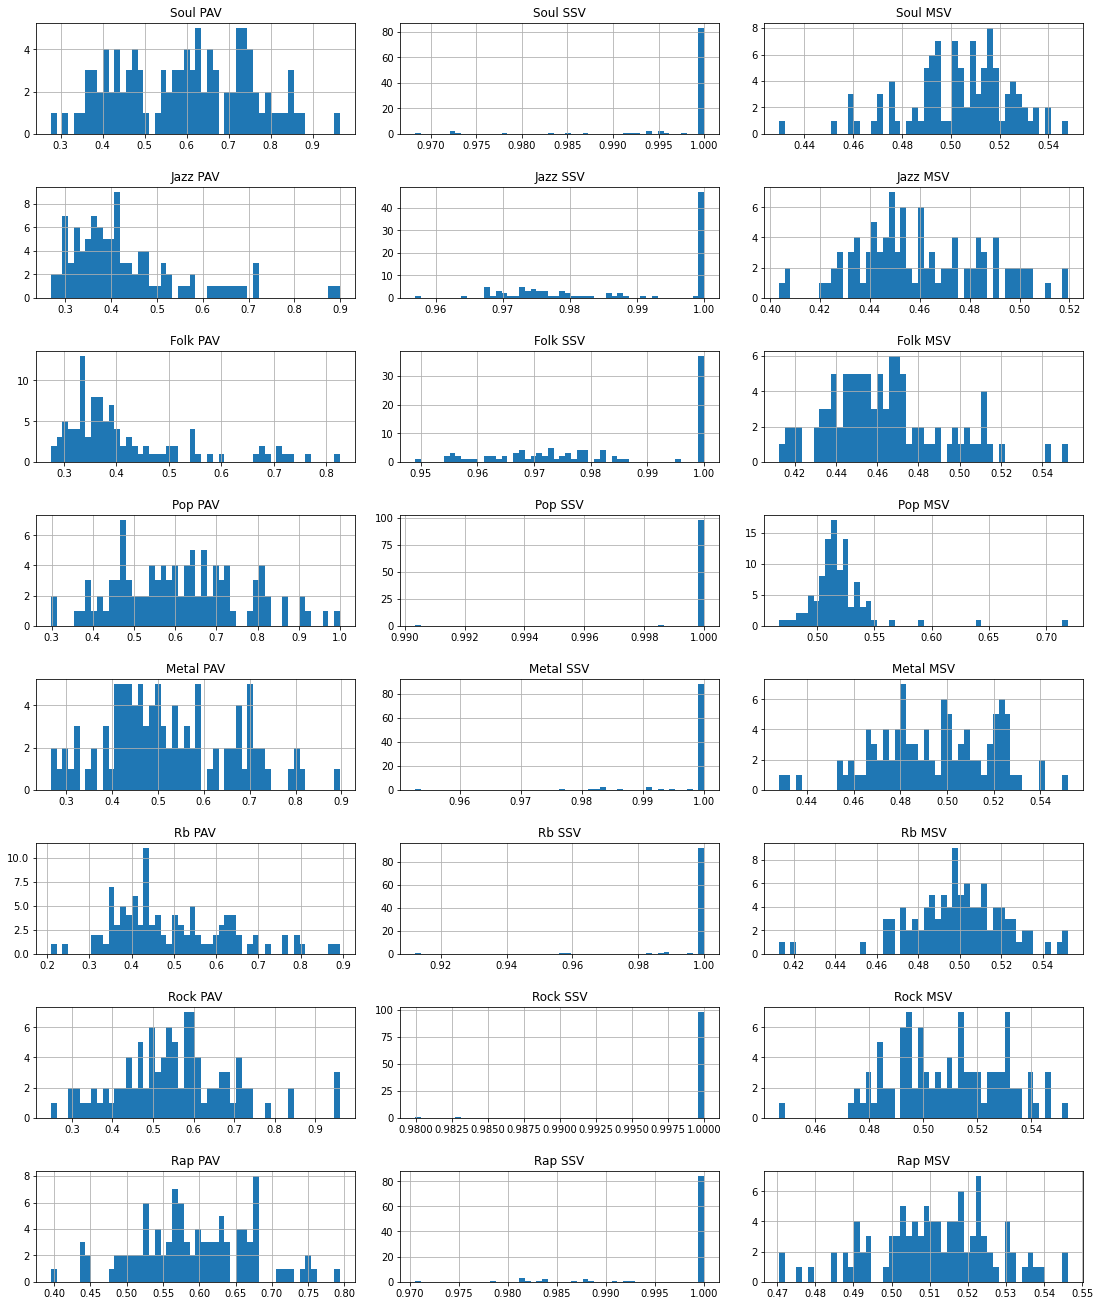

In [28]:
import matplotlib.pyplot as plt
genre_list = results.keys()
fig, axes = plt.subplots(nrows=len(genre_list), ncols=3)
fig.set_size_inches(15.5, 18.5)
i=0
for k in genre_list:
  df = results[k]
  j=0
  for t in ['PAV', 'SSV', 'MSV']:
    df[t].hist(ax=axes[i,j],bins=50)
    axes[i,j].set_title( f"{k.capitalize()} {t}" )
    j=j+1
  i=i+1
fig.tight_layout(pad=2.0)

In [30]:
#Summary 
final_summary = []
for k in genre_list:
  df = results[k]
  for t in ['PAV', 'SSV', 'MSV']:    
    m = df[t].mean() 
    std = df[t].std()
    ln = [k,'Baseline',t,m,std]
    final_summary.append(ln)
final_summary_df = pd.DataFrame(final_summary,columns = ['Genre','Lyric Type','Metric Type','Mean','STD'])
print(final_summary_df.to_string(index=False))
final_summary_df.to_csv(f"{PROJECT_DIR}/metrics/Metrics_Summary_Baseline.csv")

Genre Lyric Type Metric Type     Mean      STD
 soul   Baseline         PAV 0.594814 0.154905
 soul   Baseline         SSV 0.997683 0.006507
 soul   Baseline         MSV 0.502987 0.021322
 jazz   Baseline         PAV 0.432553 0.127746
 jazz   Baseline         SSV 0.987461 0.013129
 jazz   Baseline         MSV 0.460539 0.025635
 folk   Baseline         PAV 0.418516 0.123611
 folk   Baseline         SSV 0.981586 0.016085
 folk   Baseline         MSV 0.463349 0.027664
  pop   Baseline         PAV 0.611358 0.151090
  pop   Baseline         SSV 0.999889 0.000974
  pop   Baseline         MSV 0.519775 0.029757
metal   Baseline         PAV 0.523552 0.138445
metal   Baseline         SSV 0.998142 0.006396
metal   Baseline         MSV 0.494386 0.024745
   rb   Baseline         PAV 0.497433 0.137684
   rb   Baseline         SSV 0.997704 0.010793
   rb   Baseline         MSV 0.499116 0.023511
 rock   Baseline         PAV 0.556217 0.140426
 rock   Baseline         SSV 0.999628 0.002627
 rock   Basel